# ClinVar Dataset


In [1]:
print('Importing libraries: started')

Importing libraries: started


In [104]:
# Import libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import os as os 
import time as time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score,accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [105]:
os.getcwd()

"C:\\Users\\qaedi\\OneDrive - Queen's University\\Documents\\clinvar"

## Adding EVE score 

In [106]:
# store data into a variable
df = pd.read_csv("finalClin_3.csv", encoding='latin-1')
vdf = pd.read_csv("val_df.csv", encoding='latin-1')
ss = pd.read_csv("ss_df_2.csv", encoding='latin-1')
#list(df.columns.values)
print("main data frame" ,df.shape)
print("validation data frame", vdf.shape)
print("single submitter data frame", ss.shape)

main data frame (187493, 50)
validation data frame (28993, 50)
single submitter data frame (690455, 50)


In [107]:
#concating dataframes
l = [df,vdf, ss]
df = pd.concat(l, ignore_index = True)
df.shape

(906941, 50)

In [108]:
df.head()

,class,ID,SYMBOL,Allele,CLNVC,Consequence,IMPACT,relativeLocationRatio,ExIntron,Protein_position,...,H1.hESC_confidence_value,HUVEC_confidence_value,SiPhy_29way_logOdds,bStatistic,phastCons100way_vertebrate,GM12878_fitCons_rankscore,H1.hESC_fitCons_rankscore,HUVEC_fitCons_rankscore,phyloP30way_mammalian_rankscore,EVE_scores_ASM
0,0.0,659187,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,44,...,0.0,0.0,3.4880,929.0,0.122,0.09955,0.31042,0.5714,0.04913,NaN
1,0.0,402986,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,83,...,0.0,0.0,9.9720,929.0,0.000,0.09955,0.31042,0.5714,0.01748,NaN
2,0.0,571208,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,92,...,0.0,0.0,6.5244,929.0,0.000,0.09955,0.31042,0.5714,0.12110,NaN
3,0.0,568195,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,99,...,0.0,0.0,3.5096,929.0,0.000,0.09955,0.31042,0.5714,0.00043,NaN
4,0.0,387476,AGRN,G>C,single_nucleotide_variant,missense_variant,MODERATE,0.027778,1.0,4,...,0.0,1.0,2.0859,934.0,0.000,0.04544,0.10781,0.0843,0.01906,NaN


In [109]:
# checking type of variables
df.dtypes

class                                 float64
ID                                      int64
SYMBOL                                 object
Allele                                 object
CLNVC                                  object
Consequence                            object
IMPACT                                 object
relativeLocationRatio                 float64
ExIntron                              float64
Protein_position                       object
Codons                                 object
TSL                                   float64
Denisova                               object
SIFT                                  float64
PolyPhen                              float64
firstSubmitter                         object
submitterNo                             int64
CollectionMethod                       object
CADD_raw_rankscore_hg19               float64
ClinPred_rankscore                    float64
DANN_rankscore                        float64
Eigen.raw_coding_rankscore        

In [110]:
# dropping columns
df = df.drop(['ID', 'Protein_position', 'Codons'], axis = 1).copy()


### calculate missing values percentage in the dataset

In [111]:
# calculate missing values percentage in the dataset
num_missing = df.isnull().sum()
percentage_missing = df.isnull().sum().apply(lambda x: x/df.shape[0]*100)

missing_data = pd.DataFrame({'Number of Missing':  num_missing,
                             'Percentage of Missing': percentage_missing})

missing_data['Percentage of Missing'].sort_values(ascending = False)

EVE_scores_ASM                        86.367911
AF_TGP                                83.100996
gnomAD_genomes_NFE_AN                 79.525901
gnomAD_genomes_AFR_AF                 79.525901
gnomAD_exomes_controls_NFE_AN         77.704944
class                                 76.130090
AF                                    74.924719
MutationAssessor_rankscore            64.950642
MPC_rankscore                         64.503204
M.CAP_rankscore                       62.856128
LIST.S2_rankscore                     62.268659
FATHMM_converted_rankscore            61.956511
LRT_converted_rankscore               61.727499
SIFT                                  61.646788
MetaSVM_rankscore                     61.276092
ClinPred_rankscore                    61.161200
PolyPhen                              60.710785
fathmm.XF_coding_rankscore            60.556420
Eigen.raw_coding_rankscore            60.392903
H1.hESC_confidence_value              60.149999
GM12878_confidence_value              60

### Counting unique values

In [112]:
print('Unique values in each columns')
pd.DataFrame([[i, len(df[i].unique())] for i in df.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

Unique values in each columns


,Unique Values
Variable,
class,3
SYMBOL,3812
Allele,14
CLNVC,7
Consequence,75
IMPACT,4
relativeLocationRatio,7307
ExIntron,365
TSL,6


In [113]:
print("data dimention",df.shape)
print("count for diffrent class", df.groupby(['class']).size())

data dimention (906941, 47)
count for diffrent class class
0.0    164305
1.0     52181
dtype: int64


### defining predictors and response variables

In [114]:
print("defining the target variables and predictors")
X = df.drop('class', axis = 1).copy()
X.head()

defining the target variables and predictors


,SYMBOL,Allele,CLNVC,Consequence,IMPACT,relativeLocationRatio,ExIntron,TSL,Denisova,SIFT,...,H1.hESC_confidence_value,HUVEC_confidence_value,SiPhy_29way_logOdds,bStatistic,phastCons100way_vertebrate,GM12878_fitCons_rankscore,H1.hESC_fitCons_rankscore,HUVEC_fitCons_rankscore,phyloP30way_mammalian_rankscore,EVE_scores_ASM
0,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,G/G,0.10,...,0.0,0.0,3.4880,929.0,0.122,0.09955,0.31042,0.5714,0.04913,NaN
1,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,A/A,0.38,...,0.0,0.0,9.9720,929.0,0.000,0.09955,0.31042,0.5714,0.01748,NaN
2,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,G/G,0.13,...,0.0,0.0,6.5244,929.0,0.000,0.09955,0.31042,0.5714,0.12110,NaN
3,ISG15,G>A,single_nucleotide_variant,missense_variant,MODERATE,1.000000,2.0,NaN,G/G,0.87,...,0.0,0.0,3.5096,929.0,0.000,0.09955,0.31042,0.5714,0.00043,NaN
4,AGRN,G>C,single_nucleotide_variant,missense_variant,MODERATE,0.027778,1.0,1.0,G/G,0.12,...,0.0,1.0,2.0859,934.0,0.000,0.04544,0.10781,0.0843,0.01906,NaN


In [115]:
y = df['class'].copy()
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float64

### One-hot encoding

In [74]:
X.dtypes

SYMBOL                                 object
Allele                                 object
CLNVC                                  object
Consequence                            object
IMPACT                                 object
relativeLocationRatio                 float64
ExIntron                              float64
TSL                                   float64
Denisova                               object
SIFT                                  float64
PolyPhen                              float64
firstSubmitter                         object
submitterNo                             int64
CollectionMethod                       object
CADD_raw_rankscore_hg19               float64
ClinPred_rankscore                    float64
DANN_rankscore                        float64
Eigen.raw_coding_rankscore            float64
LIST.S2_rankscore                     float64
LRT_converted_rankscore               float64
M.CAP_rankscore                       float64
MPC_rankscore                     

In [116]:
print("One-Hot Encoding")
X_encoded = pd.get_dummies(X, columns=['SYMBOL',
                                       'Allele',
                                       'CLNVC',
                                       'Consequence',
                                       'IMPACT',
                                       'CollectionMethod',
                                       'Denisova',
                                       'TSL',
                                       'firstSubmitter'])
X_encoded.head()

One-Hot Encoding


,relativeLocationRatio,ExIntron,SIFT,PolyPhen,submitterNo,CADD_raw_rankscore_hg19,ClinPred_rankscore,DANN_rankscore,Eigen.raw_coding_rankscore,LIST.S2_rankscore,...,firstSubmitter_UNCMolecularGeneticsLaboratoryUnive,firstSubmitter_UWHindbrainMalformationResearchProg,firstSubmitter_UndiagnosedDiseasesNetworkNIH,firstSubmitter_UnitforGeneticEpidemiologicalResear,firstSubmitter_UniversityofWashingtonCenterforMend,firstSubmitter_UniversityofWashingtonDepartmentofL,firstSubmitter_VictorianClinicalGeneticsServicesMu,firstSubmitter_WomensHealthandGeneticsLaboratoryCo,firstSubmitter_WongMitoLabMolecularandHumanGenetic,firstSubmitter_other
0,1.000000,2.0,0.10,0.952,2,0.38964,0.15687,0.89085,0.38367,0.33984,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,2.0,0.38,0.003,3,0.06002,0.00038,0.15196,0.03563,0.14579,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,2.0,0.13,0.115,2,0.15404,0.19137,0.44442,0.16641,0.34650,...,0,0,0,0,0,0,0,0,0,0
3,1.000000,2.0,0.87,0.001,2,0.00104,0.00179,0.11246,0.00039,0.12095,...,0,0,0,0,0,0,0,0,0,0
4,0.027778,1.0,0.12,0.000,2,0.12689,0.00050,0.00769,0.02306,0.05533,...,0,0,0,0,0,0,0,0,0,0


In [117]:
print("data dimention",df.shape)
print("data dimention",X_encoded.shape)

data dimention (906941, 47)
data dimention (906941, 4123)


In [118]:
# seprating Validation dataset from the X and y
vdf.shape

# X_val
X_val = pd.DataFrame(X_encoded.loc[187494:216486])
#X_val.head()
print(X_val.shape)

type(y)

y_val = y.iloc[187493:216486]
print(y_val.shape)

#ss dataframe
sX = pd.DataFrame(X_encoded.loc[216486:])
print(sX.shape)

# now reverting X and y to their orginal shape
X_encoded = pd.DataFrame(X_encoded.loc[:187492])
#X_val.head()
print(X_encoded.shape)

y = y.iloc[:187493]
print(y.shape)



(28993, 4123)
(28993,)
(690455, 4123)
(187493, 4123)
(187493,)


### Basci Model

In [80]:
# checking precent of diffrent class
sum(y)/len(y)

0.26144442725861766

In [81]:
# so lets stratify by y
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42, stratify=y)


In [82]:
# # verify using stratify worked as expected
sum(y_train)/len(y_train)

0.26144404383475917

In [83]:
sum(y_test)/len(y_test)

0.26144557750565345

In [84]:
# making classifier
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            seed =42,
                            n_estimators=500)

# define the eval set and metric
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]

%time clf_xgb.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric= eval_metric, eval_set=eval_set)

C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.60232	validation_0-error:0.20361
[1]	validation_0-aucpr:0.62628	validation_0-error:0.20084
[2]	validation_0-aucpr:0.62972	validation_0-error:0.19945
[3]	validation_0-aucpr:0.64011	validation_0-error:0.19668
[4]	validation_0-aucpr:0.64502	validation_0-error:0.19653
[5]	validation_0-aucpr:0.64938	validation_0-error:0.19499
[6]	validation_0-aucpr:0.65237	validation_0-error:0.19422
[7]	validation_0-aucpr:0.65512	validation_0-error:0.19358
[8]	validation_0-aucpr:0.65739	validation_0-error:0.19281
[9]	validation_0-aucpr:0.65956	validation_0-error:0.19256
[10]	validation_0-aucpr:0.66400	validation_0-error:0.19228
[11]	validation_0-aucpr:0.66866	validation_0-error:0.19083
[12]	validation_0-aucpr:0.67072	validation_0-error:0.19064
[13]	validation_0-aucpr:0.67312	validation_0-error:0.18955
[14]	validation_0-aucpr:0.67359	validation_0-error:0.18912
[15]	validation_0-aucpr:0.67391	validation_0-error:0.18889
[16]	validation_0-aucpr:0.67581	validation_0-error:0.18812
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [85]:
#Model assessment
pred_test = clf_xgb.predict(X_test)
pred_train = clf_xgb.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8227266585596541
Test Accuraccy:  0.8174041046208986
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88     34619
         1.0       0.74      0.47      0.57     12255

    accuracy                           0.82     46874
   macro avg       0.78      0.71      0.73     46874
weighted avg       0.81      0.82      0.80     46874



In [54]:
#Model assessment without EVE
#Train Accuracy:  0.7809684324308949
#Test Accuraccy:  0.7749711993855869
#Classification Report:
#              precision    recall  f1-score   support
#
#           0       0.79      0.95      0.86     34619
#           1       0.66      0.28      0.40     12255
#
#    accuracy                           0.77     46874
#   macro avg       0.73      0.62      0.63     46874
# weighted avg       0.76      0.77      0.74     46874

In [55]:
# #plotting auc
# # retrieve performance metrics
# results = clf_xgb.evals_result()
# epochs = len(results['validation_0']['error'])
# x_axis = range(0, epochs)
# fig, ax = plt.subplots(1, 2, figsize=(15,5))
# # plot auc
# ax[0].plot(x_axis, results['validation_0']['aucpr'], label='Train')
# ax[0].plot(x_axis, results['validation_1']['aucpr'], label='Test')
# ax[0].legend()
# ax[0].set_title('XGBoost AUC-ROC')
# ax[0].set_ylabel('AUC-ROC')
# ax[0].set_xlabel('N estimators')
# # plot classification error
# ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
# ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
# ax[1].legend()
# ax[1].set_title('XGBoost Classification Error')
# ax[1].set_ylabel('Classification Error')
# ax[1].set_xlabel('N estimators')
# plt.tight_layout()
# plt.savefig("performance_with_EVE.png")
# plt.show()

plotting the performance


C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


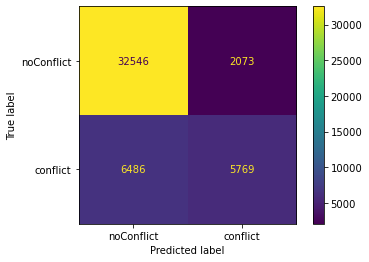

In [76]:
print('plotting the performance')
#
clf_xgb2 = clf_xgb

plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ['noConflict', 'conflict'])
plt.savefig('confMat_with_EVE.png') 

The model correctly classified:  32,546 (94%) variants out of 32,546 + 2,073 as noConflict variants. 


                                 6,486 (53%) variants out of 6486 + 5769 as conflicting variants

### Hyper-parameters tuning

Defining the value for 'scale_pos_weight':
    
    number of negative cases (majority group) / number of positive cases (minority group)
    
    
    scale_pos_weight = 138474/49019 = 2.82

### Approach 1: Using Hyperopt library

In [38]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 0
#     }

param_grid  = {
    'learning_rate': [0.1, 0.3, 0.5],
    'gamma': [0,1,2],
    'reg_lambda' : [0,1.0,10.0],
    'scale_pos_weight' : [1,3,5]
}


space={'gamma':hp.uniform ('gamma', 0,9),
        'learning_rate': hp.uniform('learning_rate', 0.1, 0.8),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 5),
        'reg_lambda': hp.uniform('reg_lambda', 1.0, 10.0),                       
    }

In [40]:
def objective(space):
    clf=xgb.XGBClassifier(
                    gamma = space['gamma'],
                    learning_rate = space['learning_rate'],
                    reg_lambda = space['reg_lambda'],
                    use_label_encoder=False ,
                    seed = 42,
                    scale_pos_weight = space['scale_pos_weight'],
                    n_estimators = 500)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [41]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.8130946793531595                                     
SCORE:                                                                               
0.8153560609292998                                                                   
SCORE:                                                                               
0.8118573196228186                                                                   
SCORE:                                                                               
0.7310449289584845                                                                   
SCORE:                                                                               
0.735567692110765                                                                    
SCORE:                                                                               
0.7185646627128045                                                                   
SCORE:                      

SCORE:                                                                                   
0.8174467721978069                                                                       
SCORE:                                                                                   
0.7181806545206297                                                                     
SCORE:                                                                                 
0.7966676622434612                                                                     
SCORE:                                                                                 
0.8142680377181379                                                                     
SCORE:                                                                                 
0.8182574561590648                                                                     
SCORE:                                                                                 
0.7912915475530145        

In [42]:

print(best_hyperparams)

The best hyperparameters are :  

{'gamma': 3.6515303677736166, 'learning_rate': 0.24633323285520856, 'reg_lambda': 6.219346093199228, 'scale_pos_weight': 1.22040601122064}


Because th tunning can take time, if I hit run by mistake the result wont show up up until the job get done. So I am pasting the best parameters here:
    
    {'gamma': 3.6515303677736166, 'learning_rate': 0.24633323285520856, 'reg_lambda': 6.219346093199228, 'scale_pos_weight': 1.22040601122064}

### Aproach 2 using GridSearchCV and RandomizedsearchCV

In [32]:
# ## ROUND 1 
param_grid  = {
    'learning_rate': [0.1, 0.3, 0.5],
    'gamma': [0,1,2],
    'reg_lambda' : [0,1.0,10.0],
    'scale_pos_weight' : [1,3,5]
}

In [20]:
## NOTE: To speed up cross validation, and to further prevent overfitting. 
## We are only using a random subset of the data (90%) and are only using a subset of features (columns) (50%) per tree.

estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                              seed =42,
                              subsample=0.9,
                              colsample_bytree=0.5,
                              max_depth = 5,
                              use_label_encoder=False)

# optimal_params = RandomizedSearchCV(
#     estimator = estimator,
#     param_distributions= param_grid,
#     scoring = 'roc_auc',
#     verbose = 3,
#     n_jobs = -1,
#     cv = 5
# )

optimal_params = GridSearchCV(
    estimator = estimator,
    param_grid= param_grid,
    scoring = 'roc_auc',
    verbose = 3,
    n_jobs = 1,
    cv = 5
)


# optimal_params.fit(X_train,
#                   y_train,
#                   early_stopping_rounds = 5,
#                   eval_metric = 'aucpr',
#                   eval_set = [(X_test, y_test)],
#                   verbose=True)

best_model = optimal_params.fit(X_train,
                  y_train,
                  early_stopping_rounds = 5,
                  eval_metric = 'aucpr',
                  eval_set = [(X_test, y_test)],
                  verbose=True)

NameError: name 'param_grid' is not defined

In [34]:
print(best_model.best_params_)
#{'gamma': 0, 'learning_rate': 0.3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}

{'gamma': 0, 'learning_rate': 0.3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}


### Best model performance

In [120]:
# Classifer based on hyperopt library
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective = 'binary:logistic',
                            gamma = 3.65,
                            reg_lambda = 6.219,
                            learning_rate = 0.246,
                            max_depth = 6,
                            scale_pos_weight =  1.22,
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators=500,
                            use_label_encoder=False)
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]

clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds  =10,
            eval_metric = eval_metric,
            eval_set = eval_set)



[0]	validation_0-aucpr:0.51215	validation_0-error:0.23491
[1]	validation_0-aucpr:0.61939	validation_0-error:0.19953
[2]	validation_0-aucpr:0.62575	validation_0-error:0.19704
[3]	validation_0-aucpr:0.62814	validation_0-error:0.19698
[4]	validation_0-aucpr:0.63257	validation_0-error:0.19646
[5]	validation_0-aucpr:0.63758	validation_0-error:0.19589
[6]	validation_0-aucpr:0.64399	validation_0-error:0.19514
[7]	validation_0-aucpr:0.64804	validation_0-error:0.19399
[8]	validation_0-aucpr:0.65159	validation_0-error:0.19339
[9]	validation_0-aucpr:0.65392	validation_0-error:0.19301
[10]	validation_0-aucpr:0.65702	validation_0-error:0.19185
[11]	validation_0-aucpr:0.65922	validation_0-error:0.19177
[12]	validation_0-aucpr:0.66025	validation_0-error:0.19164
[13]	validation_0-aucpr:0.66192	validation_0-error:0.19107
[14]	validation_0-aucpr:0.66226	validation_0-error:0.19087
[15]	validation_0-aucpr:0.66368	validation_0-error:0.19051
[16]	validation_0-aucpr:0.66526	validation_0-error:0.19010
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3.65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.246, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.219, scale_pos_weight=1.22, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [118]:
# final model assessment
pred_test = clf_xgb.predict(X_test)
pred_train = clf_xgb.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))


Train Accuracy:  0.8247889687737788
Test Accuraccy:  0.8182787899475189
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     34619
           1       0.70      0.53      0.60     12255

    accuracy                           0.82     46874
   macro avg       0.78      0.72      0.74     46874
weighted avg       0.81      0.82      0.81     46874



plotting the performance


C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


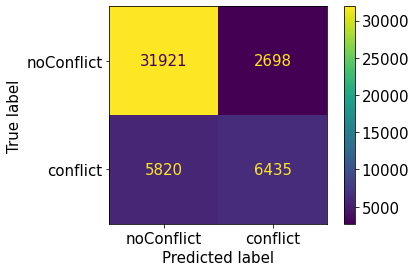

In [102]:
print('plotting the performance')
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ['noConflict', 'conflict'])
plt.savefig('confMat_with_EVE_optimized.png') 

#### performance on validation set

In [119]:
# final model assessment
pred_val = clf_xgb.predict(X_val)
pred_train = clf_xgb.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Validation test accuraccy: ', accuracy_score(y_val, pred_val))
print('Classification Report:')
print(classification_report(y_val,pred_val))



Train Accuracy:  0.8247889687737788
Validation test accuraccy:  0.881626599524023
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     25831
           1       0.35      0.10      0.15      3162

    accuracy                           0.88     28993
   macro avg       0.62      0.54      0.54     28993
weighted avg       0.84      0.88      0.85     28993



In [27]:
# Optimized to discover conflictig events weighted 
# Classifer based on hyperopt library
conflict_clf_xgb = xgb.XGBClassifier(seed=42,
                            objective = 'binary:logistic',
                            gamma = 3.65,
                            reg_lambda = 6.219,
                            learning_rate = 0.246,
                            max_depth = 6,
                            scale_pos_weight =  5,
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators=500,
                            use_label_encoder=False)
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]

conflict_clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds  =10,
            eval_metric = eval_metric,
            eval_set = eval_set)

[0]	validation_0-aucpr:0.49328	validation_0-error:0.49571
[1]	validation_0-aucpr:0.57975	validation_0-error:0.44756
[2]	validation_0-aucpr:0.59637	validation_0-error:0.43796
[3]	validation_0-aucpr:0.59944	validation_0-error:0.42672
[4]	validation_0-aucpr:0.59973	validation_0-error:0.42657
[5]	validation_0-aucpr:0.61234	validation_0-error:0.41953
[6]	validation_0-aucpr:0.63047	validation_0-error:0.40897
[7]	validation_0-aucpr:0.63567	validation_0-error:0.40656
[8]	validation_0-aucpr:0.64164	validation_0-error:0.39418
[9]	validation_0-aucpr:0.64363	validation_0-error:0.40097
[10]	validation_0-aucpr:0.64937	validation_0-error:0.37588
[11]	validation_0-aucpr:0.65458	validation_0-error:0.37180
[12]	validation_0-aucpr:0.65648	validation_0-error:0.37035
[13]	validation_0-aucpr:0.66270	validation_0-error:0.36468
[14]	validation_0-aucpr:0.66332	validation_0-error:0.36351
[15]	validation_0-aucpr:0.66460	validation_0-error:0.36325
[16]	validation_0-aucpr:0.66405	validation_0-error:0.35645
[17]	va

[139]	validation_0-aucpr:0.69449	validation_0-error:0.30307
[140]	validation_0-aucpr:0.69453	validation_0-error:0.30288
[141]	validation_0-aucpr:0.69470	validation_0-error:0.30356
[142]	validation_0-aucpr:0.69469	validation_0-error:0.30339
[143]	validation_0-aucpr:0.69485	validation_0-error:0.30337
[144]	validation_0-aucpr:0.69481	validation_0-error:0.30322
[145]	validation_0-aucpr:0.69475	validation_0-error:0.30339
[146]	validation_0-aucpr:0.69473	validation_0-error:0.30330
[147]	validation_0-aucpr:0.69489	validation_0-error:0.30341
[148]	validation_0-aucpr:0.69508	validation_0-error:0.30334
[149]	validation_0-aucpr:0.69488	validation_0-error:0.30256
[150]	validation_0-aucpr:0.69490	validation_0-error:0.30247
[151]	validation_0-aucpr:0.69498	validation_0-error:0.30239
[152]	validation_0-aucpr:0.69508	validation_0-error:0.30217
[153]	validation_0-aucpr:0.69510	validation_0-error:0.30211
[154]	validation_0-aucpr:0.69514	validation_0-error:0.30209
[155]	validation_0-aucpr:0.69520	validat

[276]	validation_0-aucpr:0.70216	validation_0-error:0.28935
[277]	validation_0-aucpr:0.70235	validation_0-error:0.28892
[278]	validation_0-aucpr:0.70250	validation_0-error:0.28892
[279]	validation_0-aucpr:0.70249	validation_0-error:0.28884
[280]	validation_0-aucpr:0.70250	validation_0-error:0.28856
[281]	validation_0-aucpr:0.70255	validation_0-error:0.28850
[282]	validation_0-aucpr:0.70263	validation_0-error:0.28871
[283]	validation_0-aucpr:0.70268	validation_0-error:0.28865
[284]	validation_0-aucpr:0.70283	validation_0-error:0.28865
[285]	validation_0-aucpr:0.70288	validation_0-error:0.28860
[286]	validation_0-aucpr:0.70287	validation_0-error:0.28856
[287]	validation_0-aucpr:0.70284	validation_0-error:0.28833
[288]	validation_0-aucpr:0.70291	validation_0-error:0.28845
[289]	validation_0-aucpr:0.70286	validation_0-error:0.28843
[290]	validation_0-aucpr:0.70290	validation_0-error:0.28850
[291]	validation_0-aucpr:0.70290	validation_0-error:0.28843
[292]	validation_0-aucpr:0.70315	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3.65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.246, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.219, scale_pos_weight=5, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [28]:
# final model assessment
pred_test = conflict_clf_xgb.predict(X_test)
pred_train = conflict_clf_xgb.predict(X_train)
pred_val = clf_xgb.predict(X_val)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Validation test accuraccy: ', accuracy_score(y_val, pred_val))

print('Classification Report on test set:')
print(classification_report(y_test,pred_test))

print("")


print('Classification Report on validation set:')
print(classification_report(y_val,pred_val))

Train Accuracy:  0.7446788840768317
Test Accuraccy:  0.7138285616759824
Validation test accuraccy:  0.8846963060048977
Classification Report on test set:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     34619
           1       0.47      0.86      0.61     12255

    accuracy                           0.71     46874
   macro avg       0.70      0.76      0.69     46874
weighted avg       0.81      0.71      0.73     46874


Classification Report on validation set:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     25831
           1       0.35      0.07      0.12      3162

    accuracy                           0.88     28993
   macro avg       0.62      0.53      0.53     28993
weighted avg       0.84      0.88      0.85     28993



### Feature importance

In [84]:
# store the winning model in a new variable
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns # for correlation heatmap


In [85]:
xgc = clf_xgb.feature_importances_
#xgc.size
# 4123 > this should be equal to the X_encoded dataset column mumber
#len(X_encoded.columns.values.tolist())
#4123

# making a dataframe from column names and FI
fimp = pd.DataFrame(data=xgc, index= X_encoded.columns.values.tolist())
# assigning colum name to the first column
fimp.rename(columns={fimp.columns[0]: "XGBoost_Feature_Importance" }, inplace = True)
fimp.sort_values('XGBoost_Feature_Importance', ascending=False, inplace=True)
# calsulate colSums
#fimp.iloc[:,0].sum()
1.0000001
# visualizing first 20 rows
fimp.head(n = 20)
# sclicing the dataframe
fimp_sliced = fimp.head(n = 20)
fimp_sliced.sort_values('XGBoost_Feature_Importance', ascending=True, inplace=True)

C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


plotting the performance


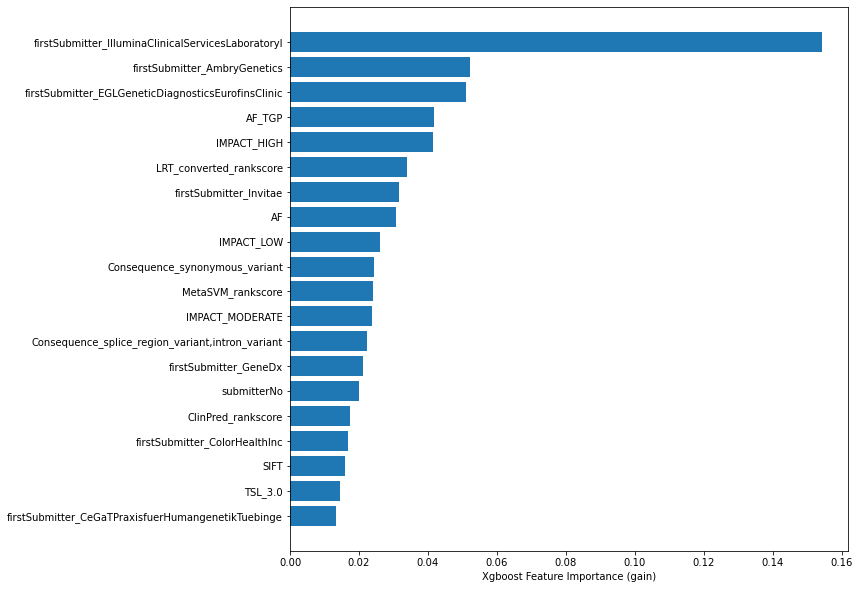

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.barh(list(fimp_sliced.index), fimp_sliced['XGBoost_Feature_Importance'])
plt.xlabel("Xgboost Feature Importance (gain)")
#plt.savefig('xgboost_feature_importance.png')
#plt.savefig('xgboost_feature_importance.png', bbox_inches='tight', dpi=300)

print('plotting the performance')
# plot_confusion_matrix(clf_xgb,
#                      X_test,
#                      y_test,
#                      values_format = 'd',
#                      display_labels = ['noConflict', 'conflict'])

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('XGBoost performance metrics')
# ax1.plot(x, y)
# ax2.plot(x, -y)

plt.savefig('feature_importance_only_gain.png', bbox_inches='tight') 

To plot the global feature importance we can use the *'plot_importances'* method. It is possible to specify one of three metrics to calculate the individual feature scores:

**Feature Weights**: the score is calculated based on the number of times the feature appears in the trees

**Gain**: the score is calculated based on the average gain of splits which use the feature

**Coverage**: the score is calculated based on the average coverage (number of samples affected by the split) of splits which use the feature

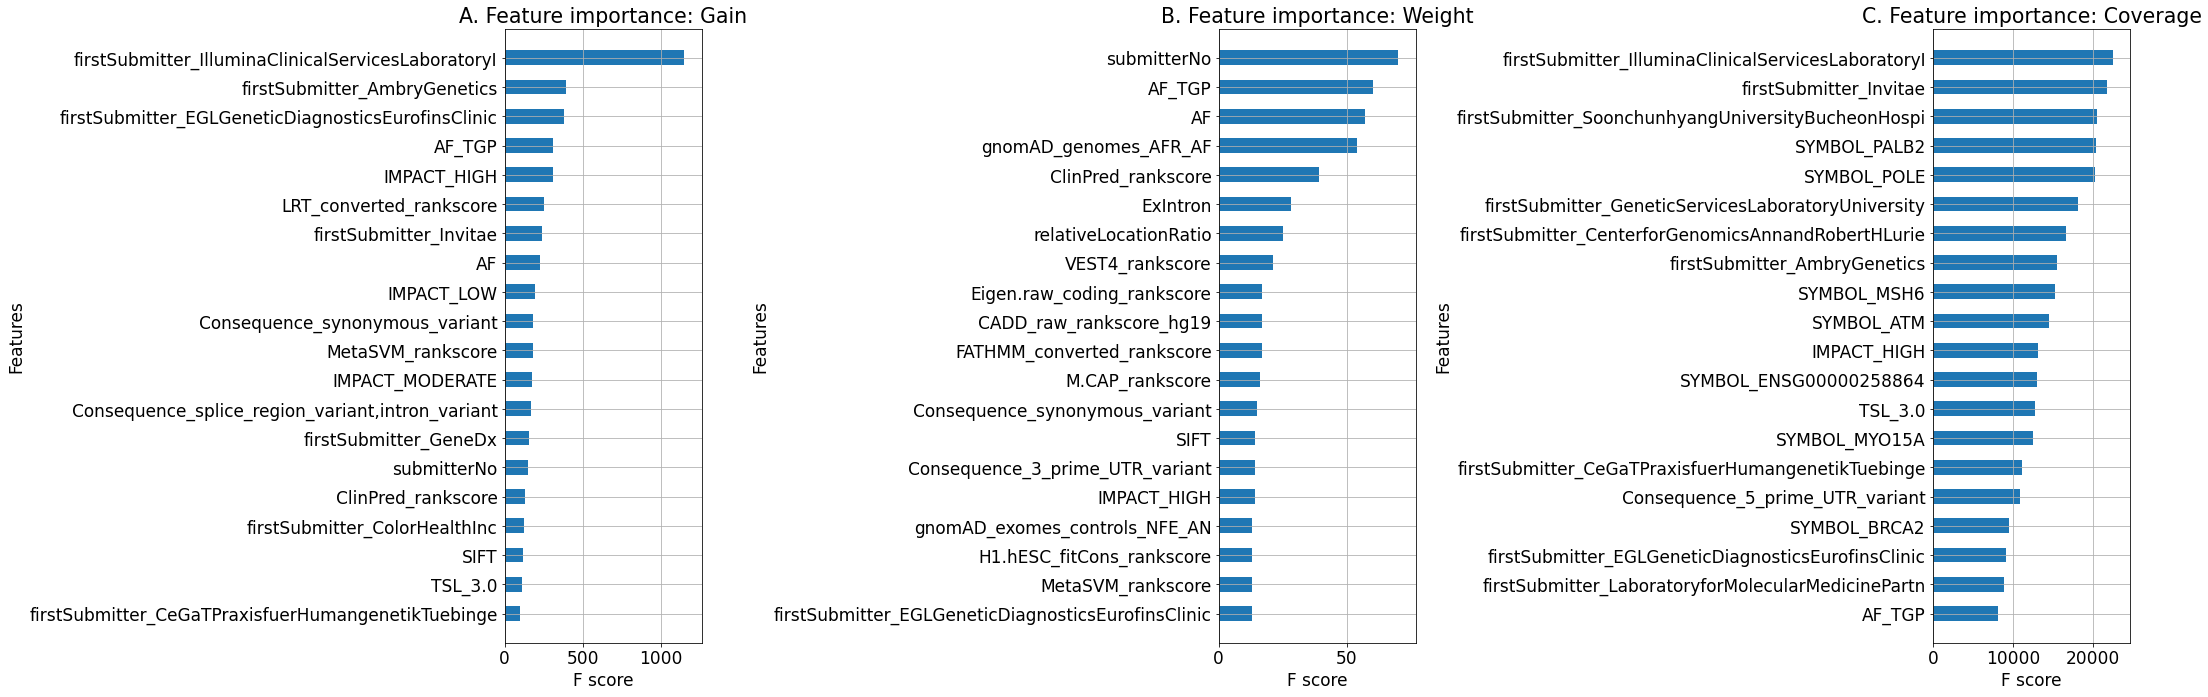

In [87]:
# Create the feature importances plot
# change font size
plt.rcParams.update({'font.size': 17})
# define panels
fig, ax = plt.subplots(1, 3, figsize=(30,10))
#plot importances with feature weight
xgb.plot_importance(
    booster=clf_xgb, 
    importance_type='weight',
    title='B. Feature importance: Weight',
    show_values=False,
    height=0.5,
    ax=ax[1],
    max_num_features=20
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=clf_xgb,
    importance_type='gain',
    title='A. Feature importance: Gain',
    show_values=False,
    height=0.5,
    ax=ax[0],
    max_num_features=20
)
# plot importances with sample coverage
xgb.plot_importance(
    booster=clf_xgb,
    importance_type='cover',
    title='C. Feature importance: Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2],
    max_num_features=20
)

# ax[0].set_title("A")
# ax[1].set_title("B")


plt.tight_layout()
plt.savefig('feature_importance.svg',format='svg', bbox_inches='tight', dpi=800)
plt.show()

Figure ?. Feature importance plots from the optimized classifier. A. Gain plot indicates the relative contribution of the features to the model performance. A higher gain value of this metric is indicative of higher importance of a feature to make prediction. B. The weight plot indicates the percentage reflecting the relative number of times a given feature occurs in the booster trees. To calculate the weight for a given feature, the number of times that feature occurred at splits in all of the trees (n = 500) is counted and then divided by number weight of all other features. We expect to see numerical features (with numerous possible values) to show higher weight as compared to the binary features (two possible values). C. The coverage plot is showing the relative number of observations related to a given feature in the model. The length of each bar is proportional to number of times that a given feature was used to decide the leaf nodes in all the trees (n = 500 trees). Here we show top 20 features in each of the sub-plots. 

C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\qaedi\anaconda3\envs\xgboost_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


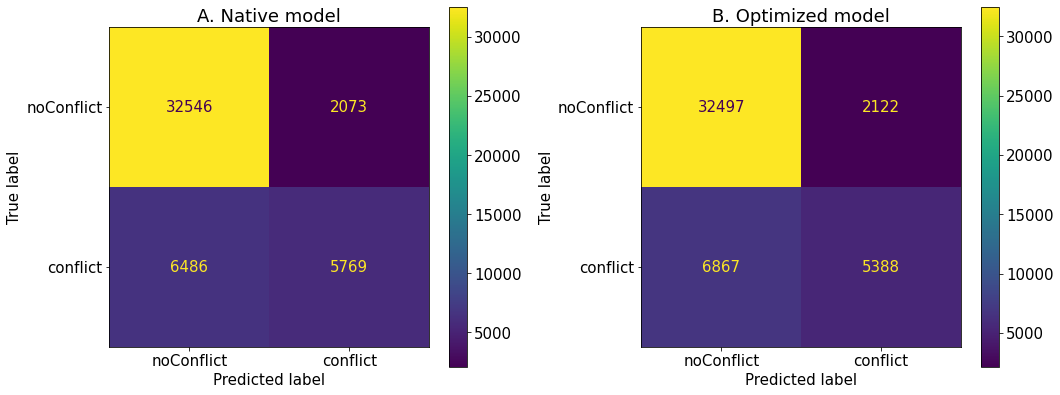

In [88]:
# Create the feature importances plot
# change font size
plt.rcParams.update({'font.size': 15})
# define panels
fig, ax = plt.subplots(1, 2, figsize=(15,6))
#plot importances with feature weight
plot_confusion_matrix(clf_xgb2,
                      X_test,
                      y_test,
                      values_format = 'd',
                      display_labels = ['noConflict', 'conflict'],
                      ax=ax[0])

plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format = 'd',
                      display_labels = ['noConflict', 'conflict'],
                      ax=ax[1])

ax[0].set_title("A. Native model")
ax[1].set_title("B. Optimized model")


plt.tight_layout()
plt.savefig('combined_conf_matrix.png', bbox_inches='tight', dpi=800)
plt.show()

# Finalize the model 

Finalize a model by applying the chosen machine learning procedure on all of the  data. In our case, we will run XGBoost with optimized hyperprametr on all of the data that we got: train + test + validation

In [13]:
# data preparing: providig all data to one hot coidn and y.
df = pd.read_csv("finalClin_3.csv", encoding='latin-1')
vdf = pd.read_csv("val_df.csv", encoding='latin-1')
l = [df,vdf]
df = pd.concat(l, ignore_index = True)

In [16]:
#defining x an y
# dropping columns
df = df.drop(['ID', 'Protein_position', 'Codons'], axis = 1).copy()

print("defining the target variables and predictors")
X = df.drop('class', axis = 1).copy()
X.head()

y = df['class'].copy()
y.head()


print("One-Hot Encoding")
X_encoded = pd.get_dummies(X, columns=['SYMBOL',
                                       'Allele',
                                       'CLNVC',
                                       'Consequence',
                                       'IMPACT',
                                       'CollectionMethod',
                                       'Denisova',
                                       'TSL',
                                       'firstSubmitter'])
X_encoded.head()

defining the target variables and predictors
One-Hot Encoding


,relativeLocationRatio,ExIntron,SIFT,PolyPhen,submitterNo,CADD_raw_rankscore_hg19,ClinPred_rankscore,DANN_rankscore,Eigen.raw_coding_rankscore,LIST.S2_rankscore,...,firstSubmitter_UNCMolecularGeneticsLaboratoryUnive,firstSubmitter_UWHindbrainMalformationResearchProg,firstSubmitter_UndiagnosedDiseasesNetworkNIH,firstSubmitter_UnitforGeneticEpidemiologicalResear,firstSubmitter_UniversityofWashingtonCenterforMend,firstSubmitter_UniversityofWashingtonDepartmentofL,firstSubmitter_VictorianClinicalGeneticsServicesMu,firstSubmitter_WomensHealthandGeneticsLaboratoryCo,firstSubmitter_WongMitoLabMolecularandHumanGenetic,firstSubmitter_other
0,1.000000,2.0,0.10,0.952,2,0.38964,0.15687,0.89085,0.38367,0.33984,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,2.0,0.38,0.003,3,0.06002,0.00038,0.15196,0.03563,0.14579,...,0,0,0,0,0,0,0,0,0,0
2,1.000000,2.0,0.13,0.115,2,0.15404,0.19137,0.44442,0.16641,0.34650,...,0,0,0,0,0,0,0,0,0,0
3,1.000000,2.0,0.87,0.001,2,0.00104,0.00179,0.11246,0.00039,0.12095,...,0,0,0,0,0,0,0,0,0,0
4,0.027778,1.0,0.12,0.000,2,0.12689,0.00050,0.00769,0.02306,0.05533,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# fINALIZED Classifer based on hyperopt library
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective = 'binary:logistic',
                            gamma = 3.65,
                            reg_lambda = 6.219,
                            learning_rate = 0.246,
                            max_depth = 6,
                            scale_pos_weight =  1.22,
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators=500,
                            use_label_encoder=False)
# # define the eval set and metric
eval_set = [(X_test, y_test)]
eval_metric = ["aucpr","error"]


clf_xgb.fit(X_encoded,
            y,
            verbose = True,
            early_stopping_rounds  =10, eval_set = eval_set, eval_metric = eval_metric)

[0]	validation_0-aucpr:0.51536	validation_0-error:0.23081
[1]	validation_0-aucpr:0.59439	validation_0-error:0.20280
[2]	validation_0-aucpr:0.62923	validation_0-error:0.19879
[3]	validation_0-aucpr:0.63206	validation_0-error:0.19574
[4]	validation_0-aucpr:0.63300	validation_0-error:0.19420
[5]	validation_0-aucpr:0.63507	validation_0-error:0.19979
[6]	validation_0-aucpr:0.63697	validation_0-error:0.19962
[7]	validation_0-aucpr:0.64675	validation_0-error:0.19273
[8]	validation_0-aucpr:0.64994	validation_0-error:0.19247
[9]	validation_0-aucpr:0.65209	validation_0-error:0.19247
[10]	validation_0-aucpr:0.65361	validation_0-error:0.19196
[11]	validation_0-aucpr:0.65586	validation_0-error:0.19207
[12]	validation_0-aucpr:0.65764	validation_0-error:0.19111
[13]	validation_0-aucpr:0.66448	validation_0-error:0.19028
[14]	validation_0-aucpr:0.66764	validation_0-error:0.18972
[15]	validation_0-aucpr:0.67178	validation_0-error:0.18946
[16]	validation_0-aucpr:0.67417	validation_0-error:0.18925
[17]	va

[139]	validation_0-aucpr:0.72540	validation_0-error:0.17163
[140]	validation_0-aucpr:0.72548	validation_0-error:0.17161
[141]	validation_0-aucpr:0.72574	validation_0-error:0.17146
[142]	validation_0-aucpr:0.72580	validation_0-error:0.17135
[143]	validation_0-aucpr:0.72607	validation_0-error:0.17146
[144]	validation_0-aucpr:0.72614	validation_0-error:0.17155
[145]	validation_0-aucpr:0.72634	validation_0-error:0.17125
[146]	validation_0-aucpr:0.72668	validation_0-error:0.17116
[147]	validation_0-aucpr:0.72678	validation_0-error:0.17112
[148]	validation_0-aucpr:0.72701	validation_0-error:0.17105
[149]	validation_0-aucpr:0.72742	validation_0-error:0.17095
[150]	validation_0-aucpr:0.72762	validation_0-error:0.17095
[151]	validation_0-aucpr:0.72760	validation_0-error:0.17097
[152]	validation_0-aucpr:0.72778	validation_0-error:0.17103
[153]	validation_0-aucpr:0.72784	validation_0-error:0.17114
[154]	validation_0-aucpr:0.72789	validation_0-error:0.17125
[155]	validation_0-aucpr:0.72796	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=3.65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.246, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=6.219, scale_pos_weight=1.22, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Save the classifier

In [121]:
# number of trees
clf_xgb.best_ntree_limit


94

In [122]:
# saving
# save in JSON format
# the following file is the best optimized model
#clf_xgb.save_model("bst.xgb.json")

# saving finalized model
#clf_xgb.save_model("finalized.xgb.json")

conflict_clf_xgb.save_model("finalized.xgb.json")



In [91]:
# loading the model
mod = xgb.XGBClassifier()
mod.load_model("bst.xgb.json")
mod2 = xgb.XGBClassifier()
mod2.load_model("finalized.xgb.json")


In [92]:
print(mod.best_ntree_limit)
print(mod2.best_ntree_limit)


94
150


In [ ]:
mod.load_model

# Working on Single submitter file

In [120]:
# loading trained classiferies

# best classifier
bst = xgb.XGBClassifier()
bst.load_model("bst.xgb.json")
# Optimized for conflict
opt = xgb.XGBClassifier()
opt.load_model("conflict_clf_xgb.json")
# finalized model
fin = xgb.XGBClassifier()
fin.load_model("finalized.xgb.json")

In [121]:
# make prediction on sX (single submitter dataframe)
bst_pred = bst.predict(sX)
#opt_pred = opt.predict(sX)

MemoryError: Unable to allocate 2.63 GiB for an array with shape (4086, 690455) and data type uint8

In [103]:
pip list

Package                       Version
----------------------------- ---------
anyio                         3.4.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
async-generator               1.10
attrs                         21.4.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bleach                        4.1.0
brotlipy                      0.7.0
certifi                       2021.10.8
cffi                          1.15.0
charset-normalizer            2.0.9
cloudpickle                   2.0.0
colorama                      0.4.4
cryptography                  36.0.1
cycler                        0.11.0
debugpy                       1.5.1
decorator                     5.1.0
defusedxml                    0.7.1
entrypoints                   0.3
flit_core                     3.6.0
future                        0.18.2
graphviz                      0.17
hyperopt                      0.2.5
idna           